<a href="https://colab.research.google.com/github/felladib/H_SentimentAnalysis_REC/blob/main/H_SCARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip uninstall tensorflow-text
!pip install tensorflow-text

# ***import lib***

In [ ]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import re
import os
from tqdm import tqdm



import keras
from keras.layers import Embedding
from keras.layers.core import Flatten
from keras.layers import Multiply, Dense, Input , Attention
from keras.models import Model
from keras.layers import concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping


import math
from time import time
import pickle
import tqdm

from tensorflow.keras.datasets import imdb
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## ***la matrice de confiance***

In [ ]:
# relu fonction permet de retourner x or 0 dans le cas ou x<0
def relu(x):
    return (np.maximum(0,x))

#  build_confidence_M fonction permet de retourner un vecteur qui contient la valeur de confiance pour chaque row (user , item ) dans notre dataset
def build_confidence_M(dataset_item, dataset_user, emb_dataset):
  # Group the user and item ratings by user_id and item_id respectively
  user_ratings = dataset_user.groupby('user_id').apply(lambda x: dict(zip(x['item_id'], x['rating'])))
  item_ratings = dataset_item.groupby('item_id').apply(lambda x: dict(zip(x['user_id'], x['rating'])))
  print(user_ratings)
  confidence_M = np.zeros(emb_dataset.shape[0]) # initialize the matrix with zeros

  for i, row in emb_dataset.iterrows():
    print('tuple : ' , i)
    user   = row['user_id']
    item   = row['item_id']
    rating = row['rating']

    # recupere le user qu'on veut lui calculer la valeur de confiance par rapport à un item
    if rating <= 3:
      # Compute the first part of the confidence value using user ratings
      user_ratings_for_item = user_ratings.get(user, {})
      filtered_ratings = [r for u, r in user_ratings_for_item.items() if u != item and r <= 3]
      if filtered_ratings:
        mean1 = sum(filtered_ratings) / len(filtered_ratings)
        result1 = -relu(abs(mean1 - rating) - 0.8)
      else:
        result1 = 0

      # Compute the second part of the confidence value using item ratings
      item_ratings_for_user = item_ratings.get(item, {})
      filtered_ratings = [r for u, r in item_ratings_for_user.items() if u != user and r <= 3]
      if filtered_ratings:
        mean2 = sum(filtered_ratings) / len(filtered_ratings)
        result2 = -relu(abs(mean2 - rating) - 0.8)
      else:
        result2 = 0

    # les meme etap si rating >3
    elif rating > 3:
      # Compute the first part of the confidence value using user ratings
      user_ratings_for_item = user_ratings.get(user, {})
      filtered_ratings = [r for u, r in user_ratings_for_item.items() if u != item and r > 3]
      if filtered_ratings:
        mean1 = sum(filtered_ratings) / len(filtered_ratings)
        result1 = -relu(abs(mean1 - rating) - 0.8)
      else:
        result1 = 0

      # Compute the second part of the confidence value using item ratings
      item_ratings_for_user = item_ratings.get(item, {})
      filtered_ratings = [r for u, r in item_ratings_for_user.items() if u != user and r > 3]
      if filtered_ratings:
        mean2 = sum(filtered_ratings) / len(filtered_ratings)
        result2 = -relu(abs(mean2 - rating) - 0.8)
      else:
        result2 = 0

    result = math.exp(result1 + result2)
    # remplire la matrice par la valeur de confiance
    confidence_M[i] = result

  return confidence_M


### Yelp


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Our_Datasets/Yelp/yelp_normalized_dataset(55738).csv') #open dataset

In [ ]:
dataset.shape

(55738, 122)

In [ ]:
dataset.head() # affichage de data set

In [ ]:
dataset.columns #affichage des colonnes

**preparer dataset_user , dataset_item**

In [ ]:
# copie les dataset pour les utilise dans la matrice de confiance
dataset_user = dataset.copy() #copie notre dataset dans dataset1
dataset_item= dataset.sort_values(by=['item_id'],axis=0, ascending = True) #tri dataset1 by items sachant que dataset est trie par users
dataset_emb= dataset.copy() # copie dataset dans dataset2

**calculer la valeur de confiance**

In [ ]:
matrice_de_confiance = build_confidence_M(dataset_item,dataset_user,dataset_emb)# remplir la matrice de confiance

In [ ]:
import numpy as np
values , counts = np.unique( matrice_de_confiance , return_counts = True) #verification que la matrice a ete bien rempli
print(values , counts)

[0.09071795 0.09525293 0.10025884 0.10464906 0.10580539 0.1071706
 0.1078598  0.10942674 0.11080316 0.11329301 0.11360815 0.11426548
 0.11532512 0.11648416 0.1169548  0.11916184 0.12071949 0.1244053
 0.1266071  0.12824072 0.1287349  0.12911409 0.12965773 0.1305024
 0.13089846 0.13199384 0.13278186 0.13326914 0.13533528 0.13693687
 0.13821465 0.13925777 0.13983282 0.14012542 0.14148585 0.14274911
 0.1439252  0.14639767 0.14701195 0.14717557 0.14956862 0.15208232
 0.15259011 0.15317251 0.15335497 0.15355688 0.15403303 0.15562322
 0.15611805 0.15652407 0.15661772 0.15693508 0.15811314 0.15811314
 0.15921497 0.15994897 0.16064289 0.16064289 0.16121764 0.16152798
 0.16185529 0.16256674 0.16321313 0.16380298 0.16529889 0.16714578
 0.16901332 0.16948345 0.16977659 0.16989936 0.17090171 0.17142038
 0.17199427 0.17253712 0.17377394 0.17444359 0.17669445 0.17669445
 0.17669445 0.17713784 0.17738873 0.17767881 0.17881052 0.17939202
 0.18128366 0.18140602 0.18167143 0.18255582 0.18268352 0.1837613

In [ ]:
# dataset['valeur_conf'] = 0
dataset['valeur_conf']=  matrice_de_confiance # ajouter une colonne qui s'appelle 'valeur_conf ' qui contient la valeur de confinace de chaque tuple(user, item)
dataset.head()

***enregistrer la valeur de confiance***

In [ ]:
dataset.to_csv(r'/content/drive/MyDrive/Our_Datasets/Yelp/yelp_normalized_dataset(55738).csv', index=False) # enregistre update dataset
dataset[:10]

,user_id,item_id,rating,text,fans,average_stars,friends,vote_funny,useful,vote_cool,...,Landscaping,Guns & Ammo,Telecommunications,Printing Services,Hair Removal,Vape Shops,Watch Repair,Party & Event Planning,Specialty Schools,valeur_conf
0,0,575,3,We don't actually dress like this but if you l...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
1,0,3529,3,I spent three hours walking around the French ...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
2,0,2126,4,"Went to the Goleta location [on Hollister, the...",0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
3,0,2764,5,I'm giving Fifi Mahoney's five stars for:\n\na...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
4,0,7990,4,"Nice selection, though not as much vintage as ...",0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
5,0,5008,3,"It looks like something out of Disneyland, exc...",0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
6,0,3437,5,This is the kind of place I would never go int...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000
7,0,6227,1,Only saw one real artist selling his own stuff...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,0.124405
8,0,2341,5,"I am from San Francisco, where all things vint...",0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,0.818731
9,0,1714,4,I can't afford any of it but loved trying it o...,0.008016,0.805851,0.012982,0.001776,0.002434,0.001527,...,0,0,0,0,0,0,0,0,0,1.000000


### Amazon_TAG

In [ ]:
amazon_= pd.read_csv('/content/drive/MyDrive/Our_Datasets/Amazon_Toys_and_Games/TAG_Dataset_Final(76307).csv')
amazon.shape
amazon.head()

,user_id,item_id,text,rating,verified,Toys & Games,Action Figures & Statues,Games,Action Figures,Dolls & Accessories,Stuffed Animals & Plush Toys,Toy Remote Control & Play Vehicles,Building Toys,Dolls,Hobbies,Building Sets,Sports & Outdoor Play,Arts & Crafts,Dress Up & Pretend Play,valeur_conf
0,0,0,I purchased this so my kids could make gifts f...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.818731
1,0,5544,"Love these kits, they are so cute!",5,True,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.000000
2,0,5530,"Just ok, thought my kids would have enjoyed t...",3,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.000000
3,0,4822,These work great in kids goody bags for partie...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
4,0,1157,Bought this for a little one but had fun on it...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000


In [ ]:
amazon_user = amazon.copy() #copie notre dataset dans dataset1
amazon_item = amazon.sort_values(by=['item_id'],axis=0, ascending = True) #tri dataset1 by items sachant que dataset est trie par users
amazon_emb = amazon.copy()

In [ ]:
matrice_de_confiance = build_confidence_M(amazon_item,amazon_user,amazon_emb)# remplir la matrice de confiance

In [ ]:
import numpy as np
values , counts = np.unique( matrice_de_confiance , return_counts = True) #verification que la matrice a ete bien rempli
print(values , counts)

In [ ]:
amazon['valeur_conf'] = 0
amazon['valeur_conf'] =  matrice_de_confiance # ajouter une colonne qui s'appelle 'valeur_conf ' qui contient la valeur de confinace de chaque tuple(user, item)
amazon.head()

,user_id,item_id,text,rating,verified,Toys & Games,Action Figures & Statues,Games,Action Figures,Dolls & Accessories,Stuffed Animals & Plush Toys,Toy Remote Control & Play Vehicles,Building Toys,Dolls,Hobbies,Building Sets,Sports & Outdoor Play,Arts & Crafts,Dress Up & Pretend Play,valeur_conf
0,0,0,I purchased this so my kids could make gifts f...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.818731
1,0,5544,"Love these kits, they are so cute!",5,True,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.000000
2,0,5530,"Just ok, thought my kids would have enjoyed t...",3,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.000000
3,0,4822,These work great in kids goody bags for partie...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
4,0,1157,Bought this for a little one but had fun on it...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000


In [ ]:
amazon.to_csv(r'/content/drive/MyDrive/Our_Datasets/Amazon_Toys_and_Games/TAG_Dataset_Final(76307).csv', index=False) # enregistre update dataset
amazon.head()

,user_id,item_id,text,rating,verified,Toys & Games,Action Figures & Statues,Games,Action Figures,Dolls & Accessories,Stuffed Animals & Plush Toys,Toy Remote Control & Play Vehicles,Building Toys,Dolls,Hobbies,Building Sets,Sports & Outdoor Play,Arts & Crafts,Dress Up & Pretend Play,valeur_conf
0,0,0,I purchased this so my kids could make gifts f...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.818731
1,0,5544,"Love these kits, they are so cute!",5,True,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.000000
2,0,5530,"Just ok, thought my kids would have enjoyed t...",3,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.000000
3,0,4822,These work great in kids goody bags for partie...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
4,0,1157,Bought this for a little one but had fun on it...,5,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000


# **Split /getnum_user_item**

In [ ]:
# dataset = pd.read_csv('/content/drive/MyDrive/Our_Datasets/Yelp/yelp_normalized_dataset(55738).csv') #réouvrire notre update dataset
dataset = pd.read_csv('/content/drive/MyDrive/yelp_normalized_dataset(55738).csv') #réouvrire notre update dataset

In [ ]:
def dataset_split(dataset): #normal testset
    # Spliting into X and y
    X = dataset[['user_id','item_id', 'text', 'fans', 'average_stars', 'friends', 'vote_funny', 'useful', 'vote_cool', 'hot', 'more',
        'profile', 'cute', 'list', 'note', 'plain', 'cool', 'funny', 'writer', 'photos',
        'Shopping','Fashion','Food','Local Services','Home Services','Grocery',
        'Drugstores','Department Stores','Flowers & Gifts','Beauty & Spas','Home Decor','Health & Medical',
        'Furniture Stores','Electronics','Sporting Goods','Cosmetics & Beauty Supply','Arts & Crafts','Accessories','Jewelry',
        'Arts & Entertainment','Event Planning & Services','Nurseries & Gardening','Appliances',
        'Shoe Stores','Discount Store','Active Life','Music & Video','Mags','Books','Hardware Stores',
        'Eyewear & Opticians','Florists','Specialty Food','Restaurants','Mobile Phones'
        'Convenience Stores','Optometrists','Used','Vintage & Consignment','Gift Shops',
        'IT Services & Computer Repair','Art Galleries','Building Supplies','Thrift Stores',
        'Automotive','Mattresses','Wine & Spirits','Beer','Hair Salons','Professional Services',
        'Kitchen & Bath','Bridal','Sports Wear','Tobacco Shops','Antiques','Pharmacy','Toy Stores',
        'Bookstores','Hobby Shops','Bikes','Nightlife','Shopping Centers','Education','Appliances & Repair',
        'Local Flavor','Photography Stores & Services','Skin Care','Bakeries','Doctors','Mobile Phone Repair',
        'Outdoor Gear','Wholesale Stores','Computers','Art Supplies','Bars','Coffee & Tea','Watches','Jewelry Repair',
        'Mobile Phone Accessories','Electronics Repair','Fruits & Veggies','Office Equipment','Venues & Event Spaces',
        'Contractors','Wedding Planning','Bike Repair/Maintenance','Ophthalmologists','Music & DVDs','Bike Rentals',
        'Formal Wear','Interior Design','Baby Gear & Furniture','Landscaping','Guns & Ammo',
        'Telecommunications','Printing Services','Hair Removal','Vape Shops','Watch Repair',
        'Party & Event Planning','Specialty Schools' , 'valeur_conf']]
    y = dataset['rating']-1
    X_train , y_train , X_test , y_test = train_test_split(X , y , test_size=0.2 , random_state=0)
    return X_train , y_train , X_test , y_test

In [ ]:
X_train, X_test, y_train, y_test = dataset_split(dataset) # split traing data and test data

In [ ]:
print("X " , X_train.shape)
print("y " , y_train.shape)
print("Xt" , X_test.shape)
print("yt" , y_test.shape)

X  (44590, 121)
y  (44590,)
Xt (11148, 121)
yt (11148,)


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
X_train.shape

(44590, 121)

In [ ]:
X_train.head()

,user_id,item_id,text,fans,average_stars,friends,vote_funny,useful,vote_cool,hot,more,profile,cute,list,note,plain,cool,funny,writer,photos,Shopping,Fashion,Food,Local Services,Home Services,Grocery,Drugstores,Department Stores,Flowers & Gifts,Beauty & Spas,Home Decor,Health & Medical,Furniture Stores,Electronics,Sporting Goods,Cosmetics & Beauty Supply,Arts & Crafts,Accessories,Jewelry,Arts & Entertainment,Event Planning & Services,Nurseries & Gardening,Appliances,Shoe Stores,Discount Store,Active Life,Music & Video,Mags,Books,Hardware Stores,Eyewear & Opticians,Florists,Specialty Food,Restaurants,Mobile PhonesConvenience Stores,Optometrists,Used,Vintage & Consignment,Gift Shops,IT Services & Computer Repair,Art Galleries,Building Supplies,Thrift Stores,Automotive,Mattresses,Wine & Spirits,Beer,Hair Salons,Professional Services,Kitchen & Bath,Bridal,Sports Wear,Tobacco Shops,Antiques,Pharmacy,Toy Stores,Bookstores,Hobby Shops,Bikes,Nightlife,Shopping Centers,Education,Appliances & Repair,Local Flavor,Photography Stores & Services,Skin Care,Bakeries,Doctors,Mobile Phone Repair,Outdoor Gear,Wholesale Stores,Computers,Art Supplies,Bars,Coffee & Tea,Watches,Jewelry Repair,Mobile Phone Accessories,Electronics Repair,Fruits & Veggies,Office Equipment,Venues & Event Spaces,Contractors,Wedding Planning,Bike Repair/Maintenance,Ophthalmologists,Music & DVDs,Bike Rentals,Formal Wear,Interior Design,Baby Gear & Furniture,Landscaping,Guns & Ammo,Telecommunications,Printing Services,Hair Removal,Vape Shops,Watch Repair,Party & Event Planning,Specialty Schools,valeur_conf
45778,1908,7562,Love the concept of a board n' brew cafe. Boar...,0.001718,0.734043,0.010400,0.000221,0.001367,0.000679,0.002605,0.001639,0.000000,0.000000,0.000000,0.005121,0.002066,0.003924,0.003924,0.001033,0.000387,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.818731
12649,457,2834,"I don't DO farms, but I did have to go here fo...",0.019181,0.651596,0.059647,0.002723,0.007286,0.002615,0.005939,0.009836,0.001442,0.003268,0.001717,0.006096,0.004944,0.003597,0.003597,0.011014,0.000290,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
40002,1635,2026,"I wish I could live here, surrounded by foliag...",0.075293,0.781915,0.085859,0.005365,0.026424,0.015045,0.005939,0.004918,0.003605,0.001634,0.000000,0.024140,0.013207,0.008502,0.008502,0.016520,0.007539,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
1611,50,4801,"I'm sorry but I hate shopping at this Acme, an...",0.159748,0.651596,0.368134,0.028000,0.082119,0.049838,0.037199,0.048361,0.030281,0.012255,0.030043,0.063887,0.036745,0.032211,0.032211,0.032869,0.003480,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.818731
38720,1582,5793,"For a large, nationwide chain, this store has ...",0.002863,0.667553,0.007422,0.000258,0.000940,0.000424,0.000729,0.004098,0.001442,0.000000,0.000000,0.002682,0.000738,0.001063,0.001063,0.002237,0.000097,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000


In [ ]:
y_train.head()

45778    3
12649    2
40002    4
1611     1
38720    4
Name: rating, dtype: int64

In [ ]:
#  getnum_user_item fonction permet de recupere le nombre de user and item dans notre dataset
def getnum_user_item(X_train):
    num_users = int(max(X_train.user_id.max()+1,X_test.user_id.max()+1))
    num_items = int(max(X_train.item_id.max()+1,X_test.item_id.max()+1))
    return num_users , num_items

num_users , num_items = getnum_user_item(X_train)

## ***BERT part***

In [ ]:
import tensorflow_text as text

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

In [ ]:
# importer le model pre-entrainer de bert pour la couche d'embedding
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

# **Splitdata_new**

In [ ]:
# dataset = pd.read_csv('/content/drive/MyDrive/Our_Datasets/Yelp/yelp_normalized_dataset(55738).csv') #réouvrire notre update dataset
dataset = pd.read_csv('/content/drive/MyDrive/yelp_normalized_dataset(55738).csv') #réouvrire notre update dataset

In [ ]:
dataset.shape

(55738, 122)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
dataset = pd.read_csv('/content/drive/MyDrive/yelp_normalized_dataset(55738).csv')

# Split into features (X) and labels (y)
X = dataset.drop(columns=['rating' ])
y = dataset['rating']

# Split into training set and remaining data
X_train, remaining_X, y_train, remaining_y = train_test_split(X, y, test_size=0.4, random_state=42)

# Identify unique users and items in training set
unique_users_train = X_train['user_id'].unique()
unique_items_train = X_train['item_id'].unique()

# Filter validation and test data
validation_data = remaining_X[remaining_X['user_id'].isin(unique_users_train) & remaining_X['item_id'].isin(unique_items_train)]
y_val = remaining_y[remaining_X['user_id'].isin(unique_users_train) & remaining_X['item_id'].isin(unique_items_train)]
test_data = remaining_X[~remaining_X.index.isin(validation_data.index)]
y_test = remaining_y[~remaining_X.index.isin(validation_data.index)]

# Split validation and test data
X_val, X_test, y_val, y_test = train_test_split(validation_data, y_val, test_size=0.5, random_state=42)

# Print sizes of training, validation, and test sets
print("Training X shape: ", X_train.shape)
print("Training y shape: ", y_train.shape)
print("Validation X shape: ", X_val.shape)
print("Validation y shape: ", y_val.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)


Training X shape:  (33442, 121)
Training y shape:  (33442,)
Validation X shape:  (10328, 121)
Validation y shape:  (10328,)
Test X shape:  (10328, 121)
Test y shape:  (10328,)


In [ ]:
#  getnum_user_item fonction permet de recupere le nombre de user and item dans notre dataset
def getnum_user_item(X_train):
    num_users = int(max(X_train.user_id.max()+1,X_test.user_id.max()+1))
    num_items = int(max(X_train.item_id.max()+1,X_test.item_id.max()+1))
    return num_users , num_items

num_users , num_items = getnum_user_item(X_train)

## ***BERT part***

In [ ]:
import tensorflow_text as text

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

In [ ]:
# importer le model pre-entrainer de bert pour la couche d'embedding
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

# **NHF model**

In [ ]:
#  cree le model NHF
def build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):

    # emb_size_hmlp : size of embedding layer for mlp  model
    # emb_size_gmf    : size of embedding layer for GMF  model
    # predictive_factors : pour le nombre d'unite des couche dense dnas la partie mlp
    # num_layers : numero de layer de mlp


    # définition des input pour les deux model gmf et mlp
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    input_userDATA = Input(shape = [17], name = 'user_data')
    input_itemDATA = Input(shape = [100], name = 'item_data')#avant shape=[49]

    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF]) # user embedding and item embedding

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3) , name= 'layer%d' %(num_layers-l+1))(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)

    #NeuHybMF part :  concatener le model gmf et mlp
    concat_NeuhMF = concatenate([mul_layer,layer])

    out = Dense(5, activation='sigmoid', name='output')(concat_NeuhMF)
    #  le model final de filtrage :

    # definir les inputs/outputs
    NHF_model = Model([input_userID,input_userDATA, input_itemID ,input_itemDATA], out)

    return NHF_model




# **model_sa (bilstm_rnn)**

***bilstm_rnn***

In [ ]:
def build_sent_model(units , droup_val):
       #model of sentiment analysis part

     # definir les inputs de notre model
     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
     # le model pre-entrainer de bert
     preprocessed_text = bert_preprocess(text_input)
     outputs = bert_encoder(preprocessed_text)

     # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
     #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

     model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2) ,
                             input_shape=(1,128,768),
                             return_sequences = True ,
                             kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4),
                             name='lstm1'))(outputs['sequence_output'])
     model_SA = tf.keras.layers.SimpleRNN(units ,
                             return_sequences = True ,
                             kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4),
                             name='lstm1')(model_SA)
     model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
     model_SA = tf.keras.layers.Flatten()(model_SA)
     model_SA = tf.keras.layers.BatchNormalization()(model_SA)
     model_SA = tf.keras.layers.Dense(120, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), name='dense1')(model_SA)
     model_SA = tf.keras.layers.Dense(5, activation='sigmoid', name='output_layer')(model_SA)

     #  confidence part :
     confidence_input = tf.keras.layers.Input(shape = [5], name = 'conf_val')

     # multiplier output de model_SA par la valeur de confiance correspondant
     model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input , model_SA])


     model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
     return  model_final_de_sentiment

In [ ]:
# def build_sent_model(units , droup_val):
#       #model of sentiment analysis part

#      # definir les inputs de notre model
#      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
#      # le model pre-entrainer de bert
#      preprocessed_text = bert_preprocess(text_input)
#      outputs = bert_encoder(preprocessed_text)

#      # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
#      #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot
#      model_SA = tf.keras.layers.Dropout(0.5)(outputs['sequence_output'])
#      model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units ,
#                              return_sequences = True ,
#                              kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4),
#                              name='lstm1'))(model_SA)
#      model_SA = tf.keras.layers.Dropout(0.5)(model_SA)
#      model_SA = tf.keras.layers.SimpleRNN(units//2 ,
#                              return_sequences = True ,
#                              kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4),
#                              name='lstm1')(model_SA)
#      model_SA = tf.keras.layers.Dropout(0.5)(model_SA)
#      model_SA = tf.keras.layers.Flatten()(model_SA)
#      model_SA = tf.keras.layers.BatchNormalization()(model_SA)
#      model_SA = tf.keras.layers.Dense(120, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3), name='dense1')(model_SA)
#      model_SA = tf.keras.layers.Dense(5, activation='sigmoid', name='output_layer')(model_SA)

#      #  confidence part :
#      confidence_input = tf.keras.layers.Input(shape = [5], name = 'conf_val')

#      # multiplier output de model_SA par la valeur de confiance correspondant
#      model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input , model_SA])


#      model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
#      return  model_final_de_sentiment

**bilstm_rnn with attention layer**

In [ ]:
import tensorflow as tf

def build_sent_model(units, dropout_val):
    # Define the inputs of our model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")

    # Preprocess the text using BERT
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    # attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(encoded_text, encoded_text)

    # Bidirectional LSTM layer
    lstm_output = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units ,
                             input_shape=(1, 128, 768),
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                             name='lstm1'))(outputs['sequence_output'])

    # Attention layer
    # attention_output = tf.keras.layers.Attention()([lstm_output, lstm_output])
    # Dropout layer
    dropout_output = tf.keras.layers.Dropout(dropout_val)(lstm_output)
    # RNN layer
    rnn_output = tf.keras.layers.SimpleRNN(units//2,
                                          #  return_sequences=True,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                                           dropout = dropout_val ,
                                           name='rnn1')(dropout_output)
    # Attention layer
    attention_output = tf.keras.layers.Attention()([rnn_output, rnn_output])

    # Flatten layer
    flatten_output = tf.keras.layers.Flatten()(attention_output)

    # Batch normalization layer
    batchnorm_output = tf.keras.layers.BatchNormalization()(flatten_output)

    # Dense layers
    dense_output = tf.keras.layers.Dense(120, activation='tanh', kernel_regularizer = tf.keras.regularizers.L1(0.001),name='dense1' )(batchnorm_output)
    output_layer = tf.keras.layers.Dense(5, activation='sigmoid', name='output_layer')(dense_output)

    # Confidence input
    confidence_input = tf.keras.layers.Input(shape=[5], name='conf_val')

    # Multiply the output of the sentiment analysis model by the confidence value
    final_output = tf.keras.layers.Multiply()([confidence_input, output_layer])

    # Define the final model
    model = tf.keras.Model(inputs=[text_input, confidence_input], outputs=[final_output])

    return model


# ***model_SA (bilstm_cnn)***

In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input        = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs           = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2) ,
                                                                  input_shape=(1,128,768),
                                                                  return_sequences = True ,
                                                                  kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                                  name='lstm1'))(outputs['sequence_output'])
    model_SA = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")(model_SA)
    model_SA = tf.keras.layers.GlobalMaxPooling1D()(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# **model_SA (lstm_rnn)**

In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.LSTM(units ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(outputs['sequence_output'])
    model_SA = tf.keras.layers.SimpleRNN(units ,
                                        return_sequences=True ,
                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                        name = 'rnn1')(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# ***model_SA (lstm_cnn)***




In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.LSTM(units ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(outputs['sequence_output'])
    model_SA = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")(model_SA)
    model_SA = tf.keras.layers.GlobalMaxPooling1D()(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    # l = tf.keras.layers.Dense(32, activation='relu', name='dense2')(l)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense2')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# **model SCARS building**

In [ ]:
def build_SCARS_model(emb_size_hmlp, emb_size_gmf, units , droup_val , predictive_factors, num_layers):
  NHF                      = build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers)
  model_final_de_sentiment = build_sent_model(units , droup_val)
  concat_SCARS             = concatenate([NHF.output , model_final_de_sentiment.output])
  SCARS_output             = Dense(1, activation='sigmoid', name='SCARS')(concat_SCARS)
  SCARS_model              = Model(inputs=[NHF.inputs, model_final_de_sentiment.inputs],outputs=SCARS_output)
  return SCARS_model

# **entrainement du model**


In [ ]:
train_userID = X_train['user_id']
train_itemID = X_train['item_id']
val_userID = X_val['user_id']
val_itemID = X_val['item_id']

In [ ]:
# print(train_userID)
# print(train_itemID)

In [ ]:
train_userDATA = X_train[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']]

train_itemDATA = X_train[['Shopping','Fashion','Food','Local Services','Home Services','Grocery',
                          'Drugstores','Department Stores','Flowers & Gifts','Beauty & Spas','Home Decor','Health & Medical',
                          'Furniture Stores','Electronics','Sporting Goods','Cosmetics & Beauty Supply','Arts & Crafts','Accessories','Jewelry',
                          'Arts & Entertainment','Event Planning & Services','Nurseries & Gardening','Appliances',
                          'Shoe Stores','Discount Store','Active Life','Music & Video','Mags','Books','Hardware Stores',
                          'Eyewear & Opticians','Florists','Specialty Food','Restaurants','Mobile Phones'
                          'Convenience Stores','Optometrists','Used','Vintage & Consignment','Gift Shops',
                          'IT Services & Computer Repair','Art Galleries','Building Supplies','Thrift Stores',
                          'Automotive','Mattresses','Wine & Spirits','Beer','Hair Salons','Professional Services',
                          'Kitchen & Bath','Bridal','Sports Wear','Tobacco Shops','Antiques','Pharmacy','Toy Stores',
                          'Bookstores','Hobby Shops','Bikes','Nightlife','Shopping Centers','Education','Appliances & Repair',
                          'Local Flavor','Photography Stores & Services','Skin Care','Bakeries','Doctors','Mobile Phone Repair',
                          'Outdoor Gear','Wholesale Stores','Computers','Art Supplies','Bars','Coffee & Tea','Watches','Jewelry Repair',
                          'Mobile Phone Accessories','Electronics Repair','Fruits & Veggies','Office Equipment','Venues & Event Spaces',
                          'Contractors','Wedding Planning','Bike Repair/Maintenance','Ophthalmologists','Music & DVDs','Bike Rentals',
                          'Formal Wear','Interior Design','Baby Gear & Furniture','Landscaping','Guns & Ammo',
                          'Telecommunications','Printing Services','Hair Removal','Vape Shops','Watch Repair',
                          'Party & Event Planning','Specialty Schools']]
val_userDATA = X_val[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']]

val_itemDATA = X_val[['Shopping','Fashion','Food','Local Services','Home Services','Grocery',
                          'Drugstores','Department Stores','Flowers & Gifts','Beauty & Spas','Home Decor','Health & Medical',
                          'Furniture Stores','Electronics','Sporting Goods','Cosmetics & Beauty Supply','Arts & Crafts','Accessories','Jewelry',
                          'Arts & Entertainment','Event Planning & Services','Nurseries & Gardening','Appliances',
                          'Shoe Stores','Discount Store','Active Life','Music & Video','Mags','Books','Hardware Stores',
                          'Eyewear & Opticians','Florists','Specialty Food','Restaurants','Mobile Phones'
                          'Convenience Stores','Optometrists','Used','Vintage & Consignment','Gift Shops',
                          'IT Services & Computer Repair','Art Galleries','Building Supplies','Thrift Stores',
                          'Automotive','Mattresses','Wine & Spirits','Beer','Hair Salons','Professional Services',
                          'Kitchen & Bath','Bridal','Sports Wear','Tobacco Shops','Antiques','Pharmacy','Toy Stores',
                          'Bookstores','Hobby Shops','Bikes','Nightlife','Shopping Centers','Education','Appliances & Repair',
                          'Local Flavor','Photography Stores & Services','Skin Care','Bakeries','Doctors','Mobile Phone Repair',
                          'Outdoor Gear','Wholesale Stores','Computers','Art Supplies','Bars','Coffee & Tea','Watches','Jewelry Repair',
                          'Mobile Phone Accessories','Electronics Repair','Fruits & Veggies','Office Equipment','Venues & Event Spaces',
                          'Contractors','Wedding Planning','Bike Repair/Maintenance','Ophthalmologists','Music & DVDs','Bike Rentals',
                          'Formal Wear','Interior Design','Baby Gear & Furniture','Landscaping','Guns & Ammo',
                          'Telecommunications','Printing Services','Hair Removal','Vape Shops','Watch Repair',
                          'Party & Event Planning','Specialty Schools']]

In [ ]:
print(train_userDATA.shape)
print(train_itemDATA.shape)

(33442, 17)
(33442, 100)


In [ ]:
import numpy as np
values , counts = np.unique( y_train , return_counts = True) #verification que la matrice a ete bien rempli
print(values , counts)

[0.2 0.4 0.6 0.8 1. ] [ 1981  2326  5588 11325 12222]


In [ ]:
from tensorflow.keras.utils import to_categorical
yt = to_categorical(y_train)
yv = to_categorical(y_val)
print(yt.shape , yv.shape)

(33442, 5) (10328, 5)


In [ ]:
y_train = tf.constant(yt, shape=[y_train.shape[0], 5])
y_val = tf.constant(yv, shape=[y_val.shape[0], 5])

In [ ]:
y_train=y_train/5
y_val=y_val/5


In [ ]:
from keras import metrics
rmse = metrics.RootMeanSquaredError()
precision = metrics.Precision()

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError
num_epochs=15
# callback = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
LR=1e-6
opt = tf.keras.optimizers.Adam(learning_rate=LR)
num_emb_mlp=8
num_emb_gmf=8
PF=16
MLPLAYERS= 5
units = 64
droup_val = 0.4
batch = 64
SCARS=build_SCARS_model(num_emb_mlp, num_emb_gmf, units , droup_val , PF, MLPLAYERS)

In [ ]:
# SCARS.summary()

In [ ]:
SCARS.compile(optimizer='sgd',
              # loss='categorical_crossentropy',
              loss="mean_absolute_error",
              metrics=[rmse , 'mae' ])

In [ ]:
# training:
column_vector = X_train['valeur_conf'].values.reshape(-1, 1)
train_conf = np.tile(column_vector, (1, 5))
# validation :
column_vector = X_val['valeur_conf'].values.reshape(-1, 1)
val_conf = np.tile(column_vector, (1, 5))

In [ ]:
history = SCARS.fit(x=[[train_userID,train_userDATA,train_itemID,train_itemDATA],X_train['text'],train_conf], y=y_train, batch_size = batch, epochs = 20,validation_data=([[val_userID,val_userDATA,val_itemID,val_itemDATA],X_val['text'],val_conf] , y_val))#,callbacks =[callback])

Epoch 1/20
523/523 [==============================] - 660s 1s/step - loss: 21.1192 - root_mean_squared_error: 0.2432 - mae: 0.1999 - val_loss: 19.6710 - val_root_mean_squared_error: 0.2141 - val_mae: 0.1646
Epoch 2/20
523/523 [==============================] - 632s 1s/step - loss: 18.3399 - root_mean_squared_error: 0.2159 - mae: 0.1663 - val_loss: 17.0321 - val_root_mean_squared_error: 0.2121 - val_mae: 0.1626
Epoch 3/20
523/523 [==============================] - 647s 1s/step - loss: 15.8064 - root_mean_squared_error: 0.2108 - mae: 0.1626 - val_loss: 14.6043 - val_root_mean_squared_error: 0.1996 - val_mae: 0.1578
Epoch 4/20
523/523 [==============================] - 647s 1s/step - loss: 13.4836 - root_mean_squared_error: 0.2014 - mae: 0.1573 - val_loss: 12.3914 - val_root_mean_squared_error: 0.1945 - val_mae: 0.1565
Epoch 5/20
523/523 [==============================] - 646s 1s/step - loss: 11.3694 - root_mean_squared_error: 0.1916 - mae: 0.1511 - val_loss: 10.3794 - val_root_mean_squar

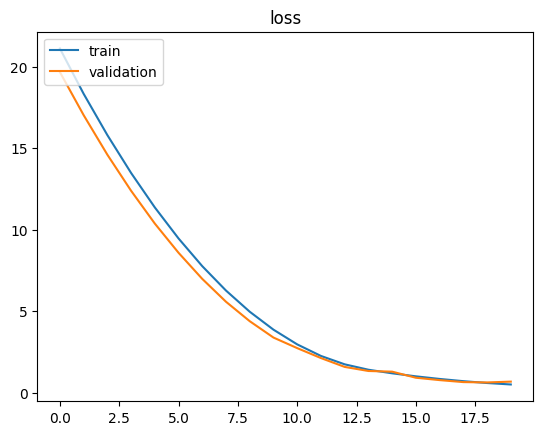

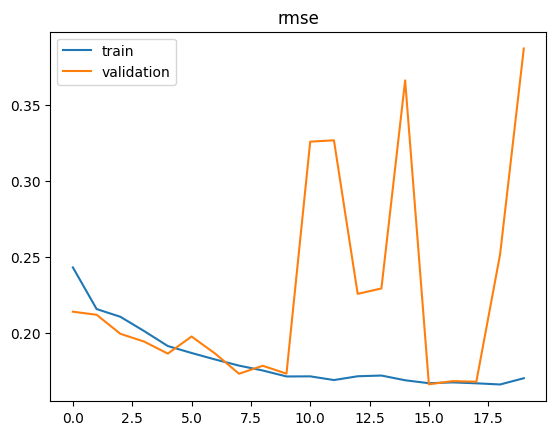

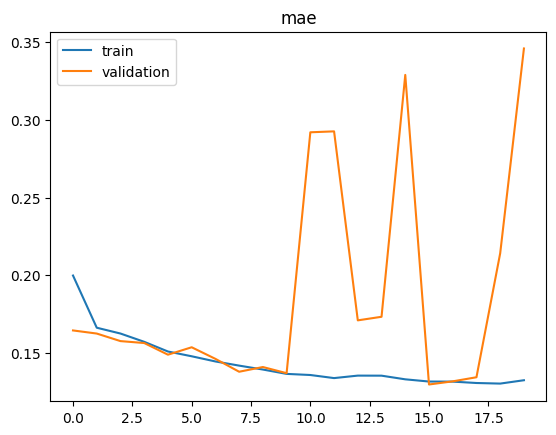

In [ ]:
from tensorflow.python.ops.array_ops import placeholder_with_default_eager_fallback
import matplotlib.pyplot as plt
loss_curve = history.history["loss"]
rmse_curve = history.history["root_mean_squared_error"]
mae_curve  = history.history["mae"]
# acc_curve  = history.history["accuracy"]

loss_val   = history.history["val_loss"]
rmse_val   = history.history["val_root_mean_squared_error"]
mae_val    = history.history["val_mae"]
# acc_val  = history.history["val_accuracy"]

# ploter loss function
def ploter (title , curve , validation):
  plt.plot(curve , label = "train")
  plt.plot(validation , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter ('loss' , loss_curve , loss_val)
ploter ('rmse' , rmse_curve , rmse_val)
ploter ('mae' , mae_curve , mae_val)
# ploter ('acc' , acc_curve , acc_val)

# **evaluation de model**

In [ ]:
test_userDATA = X_test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']]

test_itemDATA = X_test[['Shopping','Fashion','Food','Local Services','Home Services','Grocery',
                        'Drugstores','Department Stores','Flowers & Gifts','Beauty & Spas','Home Decor','Health & Medical',
                        'Furniture Stores','Electronics','Sporting Goods','Cosmetics & Beauty Supply','Arts & Crafts','Accessories','Jewelry',
                        'Arts & Entertainment','Event Planning & Services','Nurseries & Gardening','Appliances',
                        'Shoe Stores','Discount Store','Active Life','Music & Video','Mags','Books','Hardware Stores',
                        'Eyewear & Opticians','Florists','Specialty Food','Restaurants','Mobile Phones'
                        'Convenience Stores','Optometrists','Used','Vintage & Consignment','Gift Shops',
                        'IT Services & Computer Repair','Art Galleries','Building Supplies','Thrift Stores',
                        'Automotive','Mattresses','Wine & Spirits','Beer','Hair Salons','Professional Services',
                        'Kitchen & Bath','Bridal','Sports Wear','Tobacco Shops','Antiques','Pharmacy','Toy Stores',
                        'Bookstores','Hobby Shops','Bikes','Nightlife','Shopping Centers','Education','Appliances & Repair',
                        'Local Flavor','Photography Stores & Services','Skin Care','Bakeries','Doctors','Mobile Phone Repair',
                        'Outdoor Gear','Wholesale Stores','Computers','Art Supplies','Bars','Coffee & Tea','Watches','Jewelry Repair',
                        'Mobile Phone Accessories','Electronics Repair','Fruits & Veggies','Office Equipment','Venues & Event Spaces',
                        'Contractors','Wedding Planning','Bike Repair/Maintenance','Ophthalmologists','Music & DVDs','Bike Rentals',
                        'Formal Wear','Interior Design','Baby Gear & Furniture','Landscaping','Guns & Ammo',
                        'Telecommunications','Printing Services','Hair Removal','Vape Shops','Watch Repair',
                        'Party & Event Planning','Specialty Schools']]

In [ ]:
test_userID = X_test['user_id']
test_itemID = X_test['item_id']

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y_test)
y.shape

(10328, 6)

In [ ]:
y_test = tf.constant(y, shape=[y_test.shape[0], 5])

In [ ]:
y_test= y_test/5

In [ ]:
column_vector = X_test['valeur_conf'].values.reshape(-1, 1)
print(column_vector)
valeur_conf = np.tile(column_vector, (1, 5))
print(valeur_conf.shape)

[[1.        ]
 [0.94445914]
 [0.14148585]
 ...
 [1.        ]
 [1.        ]
 [0.30119421]]
(10328, 5)


In [ ]:
scores= SCARS.evaluate([[test_userID,test_userDATA,test_itemID,test_itemDATA],X_test['text'] , valeur_conf],y_test,verbose=0)

In [ ]:
scores

[0.22503142058849335,
 0.2312743216753006,
 0.1681348979473114,
 0.34972888231277466]

# **++**

In [ ]:
#Create model with hybridation (user and item id AND user and item DATA)
def build_SCARS_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    print('SCARS MODEL ')
    #NHF part
    NHF = build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers)
    print(NHF.output )
    print(NHF.input )

    #model of sentiment analysis part

    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1'))(outputs['sequence_output'])
    model_SA = tf.keras.layers.SimpleRNN(32 ,
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(model_SA)
    model_SA = tf.keras.layers.Dropout(0.5)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='relu', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')
    # confidence_model = tf.keras.layers.Dense(1, activation ='sigmoid')(confidence_input)

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input , model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    print(model_final_de_sentiment.output)
    print(model_final_de_sentiment.input)

    #  concatener NHF avec le model de sentiment
    concat_SCARS = concatenate([NHF.output , model_final_de_sentiment.output])


    out = Dense(1, activation='linear', name='SCARS')(concat_SCARS)

    SCARS_model = Model(inputs=[NHF.inputs, model_final_de_sentiment.inputs],outputs=out)

    return SCARS_model